## Import Libs

In [8]:
import os,sys
# install deepspeech - https://github.com/SeanNaren/deepspeech.pytorch
os.environ["CUDA_VISIBLE_DEVICES"] = "6"

import torch
import torch.nn as nn
import hydra


from hydra.core.config_store import ConfigStore
from deepspeech_pytorch.configs.inference_config import EvalConfig
from deepspeech_pytorch.loader.data_loader import SpectrogramDataset, AudioDataLoader
from deepspeech_pytorch.utils import load_model, load_decoder
from deepspeech_pytorch.validation import run_evaluation
from deepspeech_pytorch.model import DeepSpeech, SequenceWise

from utils import *

from ctc_loss_imp import ctc_loss_imp
import matplotlib
%matplotlib inline



In [9]:
# ------------------------------------------------------------------------------
# Config 
# ------------------------------------------------------------------------------
cs = ConfigStore.instance()
cs.store(name="config", node=EvalConfig)

cfg = EvalConfig()

# set bs = 1, device
cfg.batch_size=1
device = torch.device("cuda" if cfg.model.cuda else "cpu")


# ------------------------------------------------------------------------------
# Model
# ------------------------------------------------------------------------------
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/librispeech_pretrained_v3.ckpt'
model_path='/scratch/f006pq6/projects/gitrepos/deepspeech.pytorch/outputs/2023-11-01/23-31-50/lightning_logs/version_0/checkpoints/epoch=5-step=19295.ckpt'
model_ds = DeepSpeech.load_from_checkpoint(model_path)
model_ds.train()
model_ds = model_ds.to(device)

# ------------------------------------------------------------------------------
# Data
# ------------------------------------------------------------------------------

test_dir = '/scratch/f006pq6/datasets/librispeech/test_clean'
test_dataset = SpectrogramDataset(
    audio_conf=model_ds.spect_cfg,
    input_path=hydra.utils.to_absolute_path(test_dir),
    labels=model_ds.labels,
    normalize=True
)
test_loader = AudioDataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    num_workers=cfg.num_workers
)
# ------------------------------------------------------------------------------
# Get an Input
# ------------------------------------------------------------------------------


inputs, targets, input_percentages, target_sizes = next(iter(test_loader)) 
inputs = inputs.to(device)
targets = targets.to(device)


# # ==============================================================================
# # Make the input a bit smaller

inputs = inputs[:,:,:,-65:-40] # do 100 frames only
input_percentages[0] = 1.0
input_sizes = input_percentages.mul_(int(inputs.size(3))).int()
input_percentages = input_percentages.to(device)

print('input shape:',inputs.shape)


input shape: torch.Size([1, 1, 161, 25])


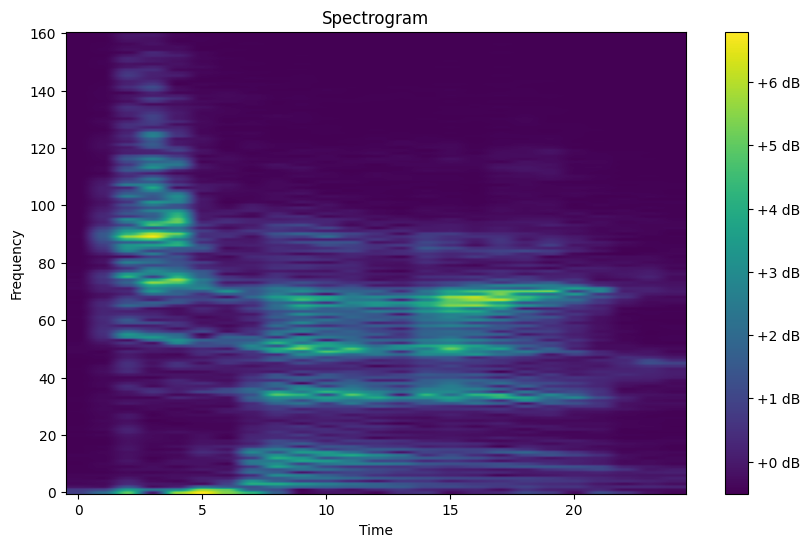

In [10]:
plot_spectrogram(inputs.detach())

In [25]:
# ------------------------------------------------------------------------------
#  Loss function, get target dL/dW
# ------------------------------------------------------------------------------
##get the param to match gradient
weight_param = model_ds.fc[0].module[1].weight
# weight_param = model_simple.fc2.weight
print('weight shape:', weight_param.shape)

out, output_sizes, hs = model_ds(inputs, input_sizes) # 1 176 29

# make target same size of output size
targets = targets[-out.shape[1]:]
target_sizes[0]= len(targets)

targets = torch.nn.Parameter(targets.float(), requires_grad=True)
print('model input shape, input_sizes:', inputs.shape, input_sizes)
print('model output shape, output_sizes, hidden sizes:', out.shape, output_sizes, len(hs))
print('target sizes, targets: ', target_sizes, targets)

out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log
# from torch.nn import CTCLoss
# loss_ = CTCLoss(blank=model_ds.labels.index('_'), reduction='sum', zero_infinity=True)(out, targets, output_sizes, target_sizes)
loss_func = lambda x,y :ctc_loss_imp(x, y, output_sizes, target_sizes,reduction='mean')


loss_func_lib   = torch.nn.CTCLoss()
loss = loss_func(out, targets)
loss_lib = loss_func_lib(out, targets, output_sizes, target_sizes)
print('loss:', loss.item())
print('loss by pt lib:', loss_lib.item())
# grab gradient to match
dldw_target= torch.autograd.grad(loss, weight_param)[0]

print('grad shape:',dldw_target.shape, 'grad_norm', dldw_target.norm())


weight shape: torch.Size([29, 1024])
model input shape, input_sizes: torch.Size([1, 1, 161, 25]) tensor([25], dtype=torch.int32)
model output shape, output_sizes, hidden sizes: torch.Size([1, 13, 29]) tensor([13], dtype=torch.int32) 5
target sizes, targets:  tensor([13], dtype=torch.int32) Parameter containing:
tensor([ 5., 20., 21., 28., 21.,  9.,  6., 28., 21.,  6., 15., 21., 20.],
       device='cuda:0', requires_grad=True)
loss: 6.230847037755526
loss by pt lib: 6.230847358703613
grad shape: torch.Size([29, 1024]) grad_norm tensor(10.7748, device='cuda:0')


In [24]:
torch.autograd.grad(loss, targets)

RuntimeError: One of the differentiated Tensors appears to not have been used in the graph. Set allow_unused=True if this is the desired behavior.

In [23]:
# ------------------------------------------------------------------------------
# Meta loss
# ------------------------------------------------------------------------------
def meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param):
    loss = loss_func(output, targets)
    dldw = torch.autograd.grad(loss, weight_param, create_graph=True)[0]
    loss = ((dldw-dldw_target)**2).sum() #MSE
    #loss = 1 - torch.nn.functional.cosine_similarity(dldw.reshape(1,-1), dldw_target.reshape(1,-1))

    return loss,dldw

# ------------------------------------------------------------------------------
# Init random input
# ------------------------------------------------------------------------------

x_hat = torch.nn.Parameter(torch.rand_like(inputs).to(device),requires_grad=True)

out, output_sizes, hs = model_ds(x_hat, input_sizes) # 1 176 29
#out = model_ds(x_hat,input_sizes)
out = out.transpose(0, 1)  # TxNxH
out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

loss,dldw = meta_loss(out, targets, None, None, dldw_target,  weight_param)
print('loss, dldw norm:', loss.item(), torch.norm(dldw))

loss, dldw norm: 220.32022094726562 tensor(10.3058, device='cuda:0', grad_fn=<NormBackward1>)


In [18]:
# ------------------------------------------------------------------------------
# Train
# ------------------------------------------------------------------------------
import torch.optim as optim

optimizer = optim.Adam([x_hat], lr=1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor=.5,patience=1000)

i=0
loss_history = []
while True:

    out, output_sizes, hs = model_ds(x_hat, input_sizes) # 1 176 29
    out = out.transpose(0, 1)  # TxNxH
    out =  out.log_softmax(-1) if model_ds.training else out.log(-1) # if model in train, use log_softmax. else use log

    # mloss, dldw_f = meta_loss(output, targets, output_sizes, target_sizes, dldw_target,  weight_param)
    mloss, dldw_f = meta_loss(out, targets, None, None, dldw_target,  weight_param)


    optimizer.zero_grad()
    mloss.backward()
    grad = x_hat.grad.data

    optimizer.step()

    loss_history.append(mloss.item())

    if i % 10 == 0:
        print('Iteration, Loss, Gradient Norm, Learning Rate: {:4d}, {:.4f}, {:.4f}, {:.4f}'.format(i, mloss.item(), grad.norm().item(), optimizer.param_groups[0]["lr"]))
        scheduler.step(mloss.item())

    if (i+ 1) % 10000 == 0:
        torch.save({
            'model':model_ds.state_dict(),
            'loss_history': loss_history,
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
             }, f'model_checkpoint_{i+ 1}.pt')
        print(f'Model saved at iteration {i+ 1}')


    i+=1

Iteration, Loss, Gradient Norm, Learning Rate:    0, 75.2544, 0.1818, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   10, 52.5685, 0.5640, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   20, 31.4223, 0.5697, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   30, 17.4238, 0.2529, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   40, 13.5503, 0.1275, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   50, 10.9216, 0.1306, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   60, 9.1213, 0.0834, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   70, 7.9364, 0.0505, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   80, 7.0164, 0.0372, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:   90, 6.1860, 0.0291, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  100, 5.5045, 0.0238, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  110, 4.9601, 0.0180, 1.0000
Iteration, Loss, Gradient Norm, Learning Rate:  120, 4.5390, 0.0170, 1.0000
Iterat

KeyboardInterrupt: 

## Plot sth

In [19]:
%matplotlib inline

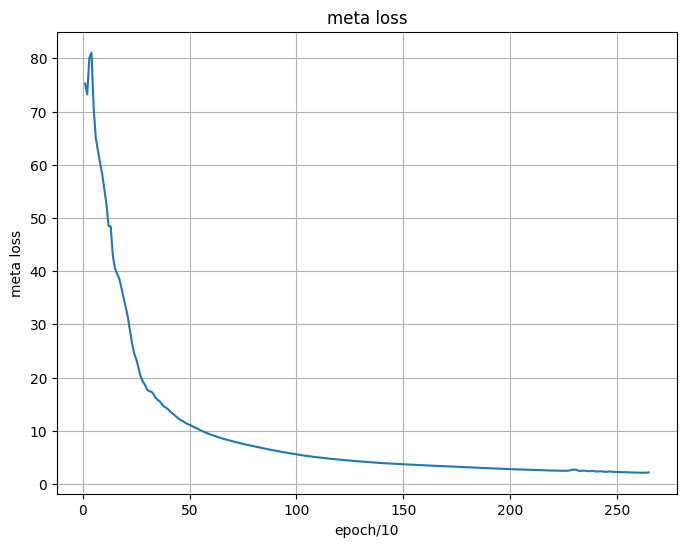

In [20]:
plot_loss_over_epoch(loss_history, 'meta loss','epoch/10','meta loss')

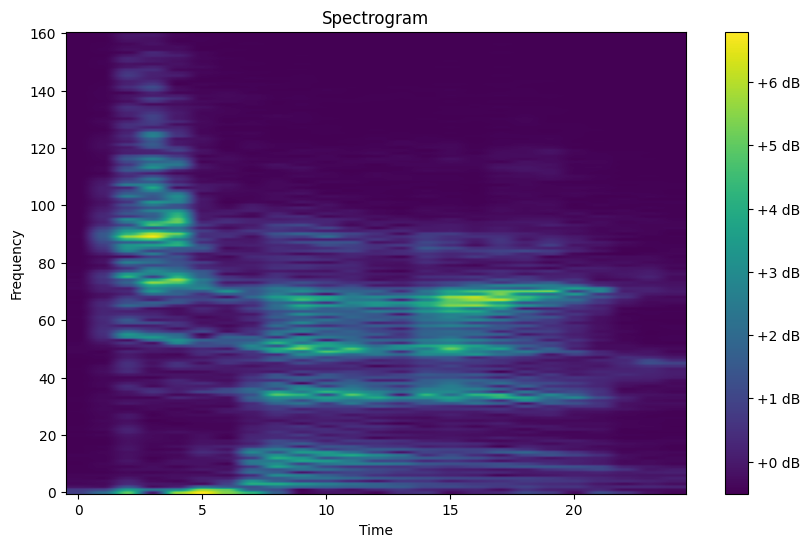

In [21]:
plot_spectrogram(inputs.detach())

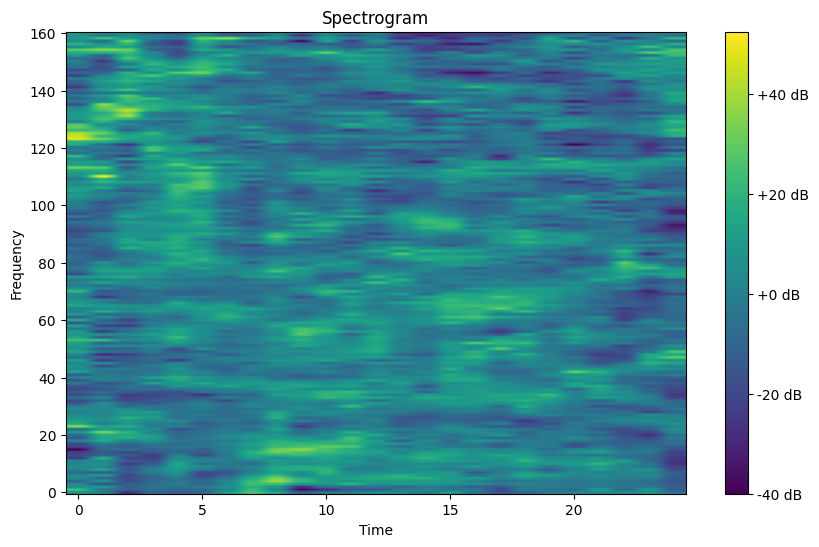

In [22]:
plot_spectrogram(x_hat.detach())

In [12]:
#pytorch 2nd order derivative test 
f = lambda x: x**3 + 2*x**2 - 3*x + 1
x = torch.tensor(1.0, requires_grad=True)

z = f(x)
y = z


dydx = torch.autograd.grad(y, x, create_graph=True)
d2ydx = torch.autograd.grad(dydx, x) # 10
print(dydx, d2ydx)

(tensor(4., grad_fn=<AddBackward0>),) (tensor(10.),)


In [43]:
plot_spectrogram(torch.abs(inputs.detach() - x_hat.detach()))

RuntimeError: The size of tensor a (25) must match the size of tensor b (20) at non-singleton dimension 3